In [25]:
import matplotlib.pyplot as plt
import numpy as np
from diffractio import um, np
from diffractio.scalar_sources_XY import Scalar_source_XY
from diffractio.scalar_masks_XY import Scalar_mask_XY
import cupy as cp
import cupyx as cpx
%matplotlib ipympl

In [26]:
# FFT method to solve diffraction at aperture
def diffractio_rs_aperture_2D(x0, 
                              y0,
                              z_prop,
                              aperture_width, 
                              wavelength,
                              draw_inputs=False):

    # Make scalar source
    u0 = Scalar_source_XY(x0, y0, wavelength)
    u0.plane_wave(z0=0)

    # Make scalar diffraction mask
    t0=Scalar_mask_XY(x0, y0, wavelength)
    t0.slit(x0=0, size=aperture_width*um, angle=0)
    t0.circle(r0=(0 * um, 0 * um), radius=(aperture_width / 2 * um, aperture_width / 2 * um), angle=0)
    u1=t0*u0
    z = z_prop
    u2 = u1.RS(z=z, new_field=True)

    if draw_inputs:
        u0.draw(kind='intensity')
        t0.draw(kind='intensity')

    return u2


In [27]:
# Cupy method
mempool = cp.get_default_memory_pool()

with cp.cuda.Device(0):
    mempool.set_limit(size=10*1024**3)

def monte_carlo_diffraction_cupy_2D(N_total, 
                                    final_image_real,
                                    final_image_imag,
                                    source_width_x,
                                    source_width_y,
                                    slit_radius,
                                    det_yx,
                                    z_prop,
                                    wavelength,
                                    batch_size=int(1e7)):  # Batch size of rays to GPU
    y_det = det_yx.shape[1]
    x_det = det_yx.shape[2]

    # Pdf to normalise ray amplitudes at beginning - for plane wave this is a constant for all rays
    pdf = 1 / (source_width_x * source_width_y)
    
    # Initialize arrays to count the number of rays per pixel
    counts = cp.zeros((y_det, x_det), dtype=cp.int32)
    for start_idx in range(0, N_total, batch_size):
        end_idx = min(start_idx + batch_size, N_total)
        current_batch_size = end_idx - start_idx

        # Get random pixel samples of the source and the detector
        source_x = cp.random.uniform(-source_width_x/2, source_width_x/2, size=current_batch_size)
        source_y = cp.random.uniform(-source_width_y/2, source_width_y/2, size=current_batch_size)
        source_z = cp.zeros(current_batch_size)
        
        # Remove rays that did not go through the aperture and form an integer mask with it
        U = (np.sqrt((source_x **2 + source_y ** 2)) < slit_radius).astype(cp.int32)

        rand_det_idx_x = cp.random.randint(x_det, size=current_batch_size)
        rand_det_idx_y = cp.random.randint(y_det, size=current_batch_size)
        
        # Find counts of rays on detector
        cp.add.at(counts, (rand_det_idx_y, rand_det_idx_x), 1)

        # Organise coordinats on detector that rays hit
        # z y x is the ordering of coordinates
        det_x = det_yx[1, rand_det_idx_y, rand_det_idx_x]
        det_y = det_yx[0, rand_det_idx_y, rand_det_idx_x]
        det_z = cp.ones(current_batch_size) * z_prop

        # Convert coordinates to a vector for computation
        ray_source_coord = cp.array([source_z, source_y, source_x])
        ray_det_coord = cp.array([det_z, det_y, det_x])
        
        # Create ray vector and get magnitude and direction
        ray = ray_det_coord - ray_source_coord
        ray_distance = cp.linalg.norm(ray, axis = 0)

        # Wavenumber
        k = 2 * np.pi / wavelength
        
        # Get amplitude and phase of all rays
        amplitude = U * (1 / ray_distance) * (1 / (2 * np.pi)) * (1j * k * z_prop / ray_distance) / pdf
        phase = (k * ray_distance)
        
        # Get diffraction field at detector by summing the point sources from the aperture. 
        complex_rays = amplitude * (np.exp(1j * phase))

        # Add complex wavefront to each pixel in the image
        cpx.scatter_add(final_image_real, (rand_det_idx_y, rand_det_idx_x), complex_rays.real)
        cpx.scatter_add(final_image_imag, (rand_det_idx_y, rand_det_idx_x), complex_rays.imag)
    
    # Add ampliude and phase together
    final_image = (final_image_real + 1j * final_image_imag)
    
    # Divide each pixel that a ray has hit by the number of counts
    non_zero_counts = counts > 0
    final_image[non_zero_counts] *= 1 / counts[non_zero_counts]
    
    # Include final factors which scale image by pixel size, and have an extra term from the rayleigh sommerfeld integral. 
    return final_image, ray_source_coord, ray_det_coord, U

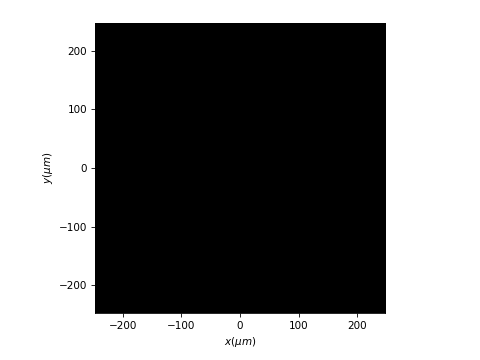

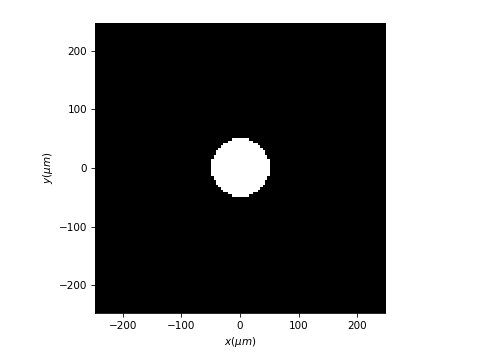

In [28]:
# Set up coordinates
aperture_diameter = 100 * um
detector_width_x = 500 * um
detector_width_y = 500 * um

# Define number of pixels on detector
num_px_det_x = 125
num_px_det_y  = 125

# Set detector width
detector_px_width_x = detector_width_x / num_px_det_x 
detector_px_width_y = detector_width_y / num_px_det_y

num_pixels = int(num_px_det_x*num_px_det_y)
det_yx_indices = np.indices((num_px_det_y, num_px_det_x)).reshape(2, num_pixels).T

# Formd the detector coordinates matrix
det_yx_coords = np.zeros(det_yx_indices.shape, dtype = np.float64)
det_yx_coords[:, 0] = det_yx_indices[:, 0] * detector_px_width_y - detector_width_y / 2  + detector_px_width_y / 2
det_yx_coords[:, 1] = det_yx_indices[:, 1] * detector_px_width_x - detector_width_x / 2  + detector_px_width_x / 2 
det_yx_coords = det_yx_coords.T.reshape(2, num_px_det_y, num_px_det_x)

# Define propagation distance after aperture
z_prop = 500 * um

# Set wavelength
wavelength = 1 * um

# Find diffraction from aperture using fourier transform integration of rayleigh sommerfeld diffraction integral
u2 = diffractio_rs_aperture_2D(x0=det_yx_coords[1, 0, :], y0=det_yx_coords[1, 0, :],
                                z_prop=z_prop, 
                                wavelength=wavelength,
                                aperture_width=aperture_diameter, 
                                draw_inputs=True)



In [29]:
# Choose number of rays
num_rays=int(1e10)

# Set source area
source_width_x = detector_width_x
source_width_y = detector_width_y

# Make cupy arrays
det_yx_coords = cp.asarray(det_yx_coords)

# Initialize final image and aperture phase shifts arrays on GPU
final_image_real = cp.zeros([num_px_det_y, num_px_det_x], dtype=cp.float64)
final_image_imag = cp.zeros([num_px_det_y, num_px_det_x], dtype=cp.float64)

final_image, ray_aper_coord, ray_det_coord, aperture_mask = monte_carlo_diffraction_cupy_2D(num_rays, 
                                                                                            final_image_real,
                                                                                            final_image_imag,
                                                                                            source_width_x,
                                                                                            source_width_y,
                                                                                            slit_radius=aperture_diameter/2,
                                                                                            det_yx=det_yx_coords,
                                                                                            z_prop=z_prop,
                                                                                            wavelength=wavelength,
                                                                                            batch_size=int(1e7),
                                                                                            )
# Convery back to numpy for plotting
det_yx_coords = cp.asnumpy(det_yx_coords)
final_image = cp.asnumpy(final_image)
ray_aper_coord = cp.asnumpy(ray_aper_coord)
ray_det_coord = cp.asnumpy(ray_det_coord)
aperture_mask = cp.asnumpy(aperture_mask)

/tmp/ipykernel_357593/1180219972.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


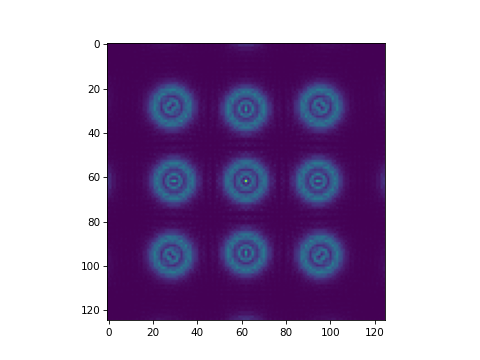

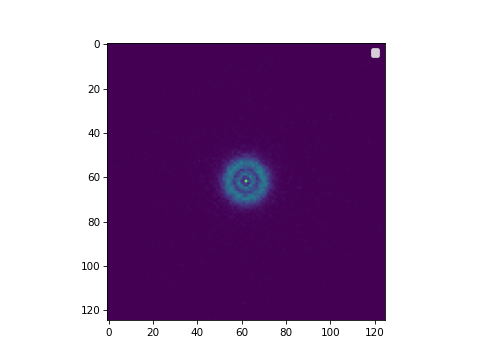

In [30]:
# Plotting
fig, ax = plt.subplots()
ax.imshow(np.abs(u2.u) ** 2, label='Fourier Integration RayLeigh Sommerfeld')

fig, ax = plt.subplots()
ax.imshow(np.abs(final_image) ** 2, label='Monte Carlo Integration RayLeigh Sommerfeld')
plt.legend()

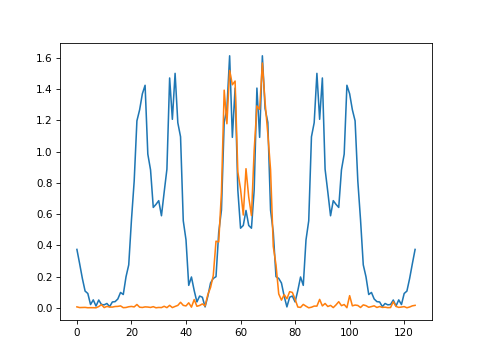

In [31]:
# Plot cross section. 
plt.figure()
plt.plot(np.abs(u2.u[67, :]) ** 2)
plt.plot(np.abs(final_image[67, :]) ** 2)

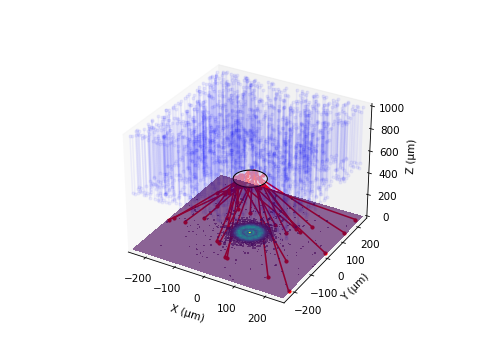

In [32]:
# Plot 3D model
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# Create figure and 3D axis
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Define the aperture (circle parameters)
radius = 50
num_points = 100
theta = np.linspace(0, 2 * np.pi, num_points)
x = radius * np.cos(theta)
y = radius * np.sin(theta)
z = np.full_like(x, 500)  # Height of 500

# Create the aperture polygon
verts = [list(zip(x, y, z))]
aperture = Poly3DCollection(verts, color='w', edgecolor='k', alpha = 0.5)

# Add the aperture to the plot
ax.add_collection3d(aperture)

# Set plot limits
ax.set_xlim(-250, 250)
ax.set_ylim(-250, 250)
ax.set_zlim(0, 1001)

# Set labels
ax.set_xlabel('X (µm)')
ax.set_ylabel('Y (µm)')
ax.set_zlabel('Z (µm)')

# Set background to black and grid off to resemble the provided image
# ax.set_facecolor('black')
ax.grid(False)


N = 1000
idx = np.random.randint(0, 10000000.0 + 1, N)

# Plot points at z=1000 and z=500
ax.plot(ray_aper_coord[1, idx], ray_aper_coord[2, idx], np.ones(N) * 1000, '.b', alpha = 0.05)
ax.plot(ray_aper_coord[1, idx], ray_aper_coord[2, idx], np.ones(N) * 500, '.b', alpha = 0.05)

# Plot lines connecting points between z=1000 and z=500
for i in range(N):
    ax.plot([ray_aper_coord[1, idx][i], ray_aper_coord[1, idx][i]],
            [ray_aper_coord[2, idx][i], ray_aper_coord[2, idx][i]],
            [1000, 500], 'b', alpha = 0.05)
    

mask = np.sqrt(ray_aper_coord[1, idx] ** 2 + ray_aper_coord[2, idx] ** 2) < radius

coords_x_aper = ray_aper_coord[2, idx][mask]
coords_y_aper = ray_aper_coord[1, idx][mask]

coords_x_det = ray_det_coord[2, idx][mask]
coords_y_det = ray_det_coord[1, idx][mask]

# Plot points at z=500 and z=0
ax.plot(coords_y_aper, coords_x_aper, np.ones(len(coords_x_det)) * 500, '.r', zorder = 1)
ax.plot(coords_y_det, coords_x_det, np.ones(len(coords_x_det)) * 0, '.r', zorder = 1)

for i in range(len(coords_x_det)):
    ax.plot([coords_y_aper[i], coords_y_det[i]],
            [coords_x_aper[i], coords_x_det[i]],
            [500, 0], 'r', zorder = 1)
    
xx, yy = np.meshgrid(np.linspace(-250, 250, 125), np.linspace(-250, 250, 125))

# create vertices for a rotated mesh (3D rotation matrix)
X =  xx 
Y =  yy
Z =  0*np.ones(X.shape)

cset = ax.contourf(Y, X, np.abs(final_image) ** 2, 100, zdir='z', offset=0.0, zorder =0, alpha = 0.6)
plt.show()